In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import open3d
from mpl_toolkits import mplot3d


In [17]:
img1 = cv2.cvtColor(cv2.imread('desk/im1.jpg',0),cv2.COLOR_GRAY2RGB)
img2 = cv2.cvtColor(cv2.imread('desk/im2.jpg',0),cv2.COLOR_GRAY2RGB)

In [18]:
FFD = cv2.FastFeatureDetector_create()
key_points1 = FFD.detect(img1,None)
key_points2 = FFD.detect(img2,None)

In [19]:
list_point1 = [i.pt for i in key_points1]
list_point2 = [i.pt for i in key_points2]


points1 = np.array(list_point1).astype(np.int16)
points2 = np.array(list_point2).astype(np.int16)
#for i,j in zip(key_points1,key_points2):
 #   list_point1.append([int(i.pt[0]),int(i.pt[1])])
  #  lis_point2.append([int(j.pt[0]),int(j.pt[1])])
    #print(tuple(int(i.pt[0]),inta(i.pt[1])))

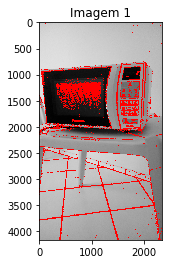

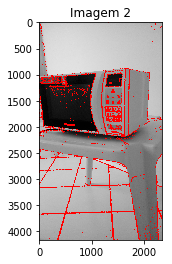

In [20]:
img1_ = img1.copy()
img2_ = img2.copy()
for x in points1:
    cv2.circle(img1_,tuple(x), 7, (255,0,0), -1)
for x2 in points2:
    cv2.circle(img2_,tuple(x2), 7, (255,0,0), -1)
plt.imshow(img1_);
plt.title("Imagem 1")
plt.show();
plt.title("Imagem 2")
plt.imshow(img2_);

In [15]:
points_pred_img2, status, error = cv2.calcOpticalFlowPyrLK(img1,img2,np.float32(points1),None)

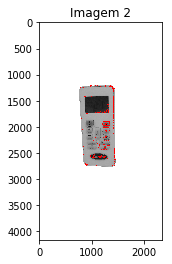

In [16]:
condition = (status == 1)*(error < 15.)
img2_ = img2.copy()
for x2,conditio in zip(points_pred_img2,condition):
    if conditio == True:
        cv2.circle(img2_,tuple(x2), 7, (255,0,0), -1)
plt.title("Imagem 2")
plt.imshow(img2_);

In [17]:
points2_correct = np.int16(points_pred_img2[condition.reshape((condition.shape[0],)) == True,:])
points1_correct = points1[condition.reshape((condition.shape[0],)) == True,:]

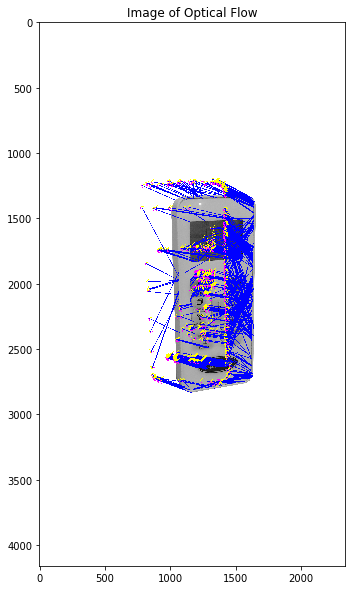

In [18]:
img1_ = img1.copy()

for pos in range(len(points1_correct)):
    cv2.line(img1_, tuple(points1_correct[pos]), tuple(points2_correct[pos]),(0,0,255),3)
     
    theta = np.arctan2(points2_correct[pos][1] -
            points1_correct[pos][1], points2_correct[pos][0] -
            points1_correct[pos][0])
    cv2.line(img1_, tuple(points2_correct[pos]),
            (np.int(points2_correct[pos][0] -
            25*np.cos(theta+np.pi/4)),
            np.int(points2_correct[pos][1] -
            25*np.sin(theta+np.pi/4))), color=(255, 0, 255),thickness=3)
    cv2.line(img1_, tuple(points2_correct[pos]),
            (np.int(points2_correct[pos][0] -
            25*np.cos(theta-np.pi/4)),
            np.int(points2_correct[pos][1] -
            25*np.sin(theta-np.pi/4))), color=(255, 255, 0),thickness=3)
plt.figure(figsize=(15,10))
plt.imshow(img1_)
plt.title("Image of Optical Flow")

plt.show();

In [34]:
import argparse
import cv2
import numpy as np
def build_arg_parser():
    parser = argparse.ArgumentParser(description='Reconstruct the3D map from the two input stereo images. Output will be saved in output.ply')
    parser.add_argument("--image-left", dest="image_left",required=True, help="Input image captured from the left")
    parser.add_argument("--image-right", dest="image_right",required=True,help="Input image captured from the right")
    parser.add_argument("--output-file", dest="output_file",required=True,help="Output filename (without the extension) wherethe point cloud will be saved")
    return parser

def create_output(vertices, colors, filename):
    colors = colors.reshape(-1, 3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(vertices)))
        np.savetxt(f, vertices, '%f %f %f %d %d %d')
        
if __name__ == '__main__':
    args = build_arg_parser().parse_args()
    image_left = cv2.imread(args.image_left)
    image_right = cv2.imread(args.image_right)
    output_file = args.output_file + '.ply'
    if image_left.shape[0] != image_right.shape[0] or image_left.shape[1] != image_right.shape[1]:
        
        raise TypeError("Input images must be of the same size")
        
imgL = cv2.pyrDown(img1)
imgR = cv2.pyrDown(img2)

usage: ipykernel_launcher.py [-h] --image-left IMAGE_LEFT --image-right
                             IMAGE_RIGHT --output-file OUTPUT_FILE
ipykernel_launcher.py: error: the following arguments are required: --image-left, --image-right, --output-file


SystemExit: 2

In [22]:
win_size = 1
min_disp = 16
max_disp = min_disp * 9
num_disp = max_disp - min_disp
# Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,numDisparities = num_disp,uniquenessRatio = 10,speckleWindowSize = 100,speckleRange = 32,disp12MaxDiff = 1,P1 = 8*3*win_size**2,P2 = 32*3*win_size**2)
disparity_map = stereo.compute(imgL,imgR).astype(np.float32) / 16.0

In [23]:
h, w = imgL.shape[:2]
focal_length = 0.8*w
# Perspective transformation matrix
Q = np.float32([[1, 0, 0, -w/2.0],
[0,-1, 0, h/2.0],
[0, 0, 0, -focal_length],
[0, 0, 1, 0]])
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
mask_map = disparity_map > disparity_map.min()
pts3D = points_3D[mask_map]
ptsC = colors[mask_map]


ValueError: 'c' argument has 503601 elements, which is not acceptable for use with 'x' with size 503601, 'y' with size 503601.

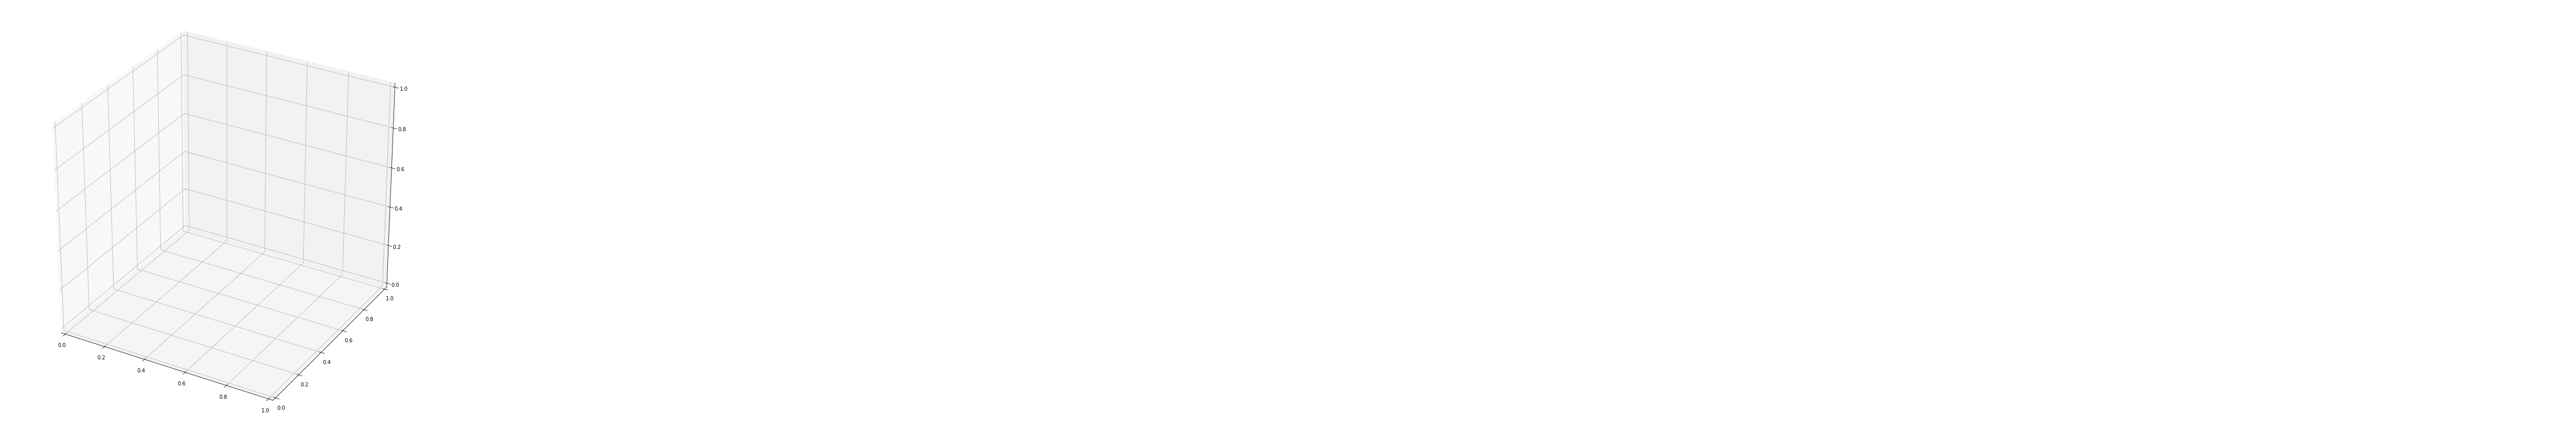

In [24]:
#points4D = cv2.triangulatePoints(Rt1,Rt2,np.float32(points1_correct.T),np.float32(points2_correct.T)).T
#pts3D = points4D[:, :3]/np.repeat(points4D[:, 3], 3).reshape(-1, 3)
#plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.scatter3D(pts3D[:,0],pts3D[:,1],pts3D[:,2],c=ptsC);

In [12]:
E, mask = cv2.findEssentialMat(points1_correct,points2_correct,focal=1.0, pp=(0., 0.), method=cv2.RANSAC,  threshold=3.0)
ptsL = points1_correct[mask.ravel()==1] # Remove pontos não escolhidos pelo RANSAC. Com apenas 8 todos são escolhidos.
ptsR = points2_correct[mask.ravel()==1]
E

array([[ 1.11822425e-04, -1.74636484e-04, -7.05453047e-01],
       [ 3.01219643e-05, -2.40449255e-06, -4.83317229e-02],
       [ 6.50623218e-01,  2.76928559e-01,  3.62454890e-05]])

In [13]:
def in_front_of_both_cameras(first_points, second_points,rot, trans):
    rot_inv = rot
    for first, second in zip(first_points, second_points):
        first_z = np.dot(rot[0, :] - second[0]*rot[2, :], trans) /np.dot(rot[0, :] - second[0]*rot[2, :], second)
        first_3d_point = np.array([first[0] * first_z, second[0] *first_z, first_z])
        second_3d_point = np.dot(rot.T, first_3d_point)-     np.dot(rot.T, trans)
    if first_3d_point[2] < 0 or second_3d_point[2] < 0:
        return False
    return True


In [15]:
U,V,vt = np.linalg.svd(E)
W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
1.0]).reshape(3, 3)

#R1 = U.dot(W).dot(vt)
#R2 = U.dot(W.T).dot(vt)
#t1 = U[:,2]
#t2 =-U[:,2]


#R = U.dot(W).dot(vt)
#T = U[:,2]
R = U.dot(W).dot(vt)
T= U[:,2]
K_inv = np.linalg.inv(mtx)

first_inliers = []
second_inliers = []
for i in range(len(mask)):
    if mask[i]:
      # normalize and homogenize the image coordinates
        first_inliers.append(K_inv.dot([points1_correct[i][0], points1_correct[i][1], 1.0]))
        second_inliers.append(K_inv.dot([points2_correct[i][0], points2_correct[i][1], 1.0]))
#cv2.convertPointsToHomogeneous(np.float32(points1_correct))        
        
if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):

    # Second choice: R = U * W * Vt, T = -u_3("")
    print("C")
    T = - U[:, 2]
    if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):
        print("A")
        # Third choice: R = U * Wt * Vt, T = u_3
        R = U.dot(W.T).dot(vt)
        T = U[:, 2]

        if not in_front_of_both_cameras(first_inliers, second_inliers, R, T):
            print("B")
            # Fourth choice: R = U * Wt * Vt, T = -u_3
            T = - U[:, 2]


Rt1 = np.hstack((np.eye(3), np.zeros((3, 1))))
Rt2 = np.hstack((R, T.reshape(3, 1)))

#------


In [ ]:
first_inliers = np.array(points1_correct).reshape(-1, 3)[:, :2]
second_inliers = np.array(points2_correct).reshape(-1, 3)[:, :2]
pts4D = cv2.triangulatePoints(Rt1, Rt2, first_inliers.T,second_inliers.T).T
pts3D = pts4D[:, :3]/np.repeat(pts4D[:, 3], 3).reshape(-1, 3)

In [25]:
points4D = cv2.triangulatePoints(Rt1,Rt2,np.float32(points1_correct.T),np.float32(points2_correct.T)).T
pts3D = points4D[:, :3]/np.repeat(points4D[:, 3], 3).reshape(-1, 3)
#plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.scatter3D(pts3D[:,2],pts3D[:,0],pts3D[:,1]);

NameError: name 'Rt1' is not defined

In [30]:
pts3D

array([[5.8683821e-05, 1.4676774e-01, 4.5526278e-05],
       [8.5671505e-05, 1.6121426e-01, 5.1160063e-05],
       [2.1228983e-04, 2.3451327e-01, 8.1634898e-05],
       ...,
       [1.0628684e-03, 8.8477212e-01, 2.7202987e-04],
       [1.0446258e-03, 8.7559271e-01, 2.6604050e-04],
       [1.0445137e-03, 8.7629944e-01, 2.6472111e-04]], dtype=float32)

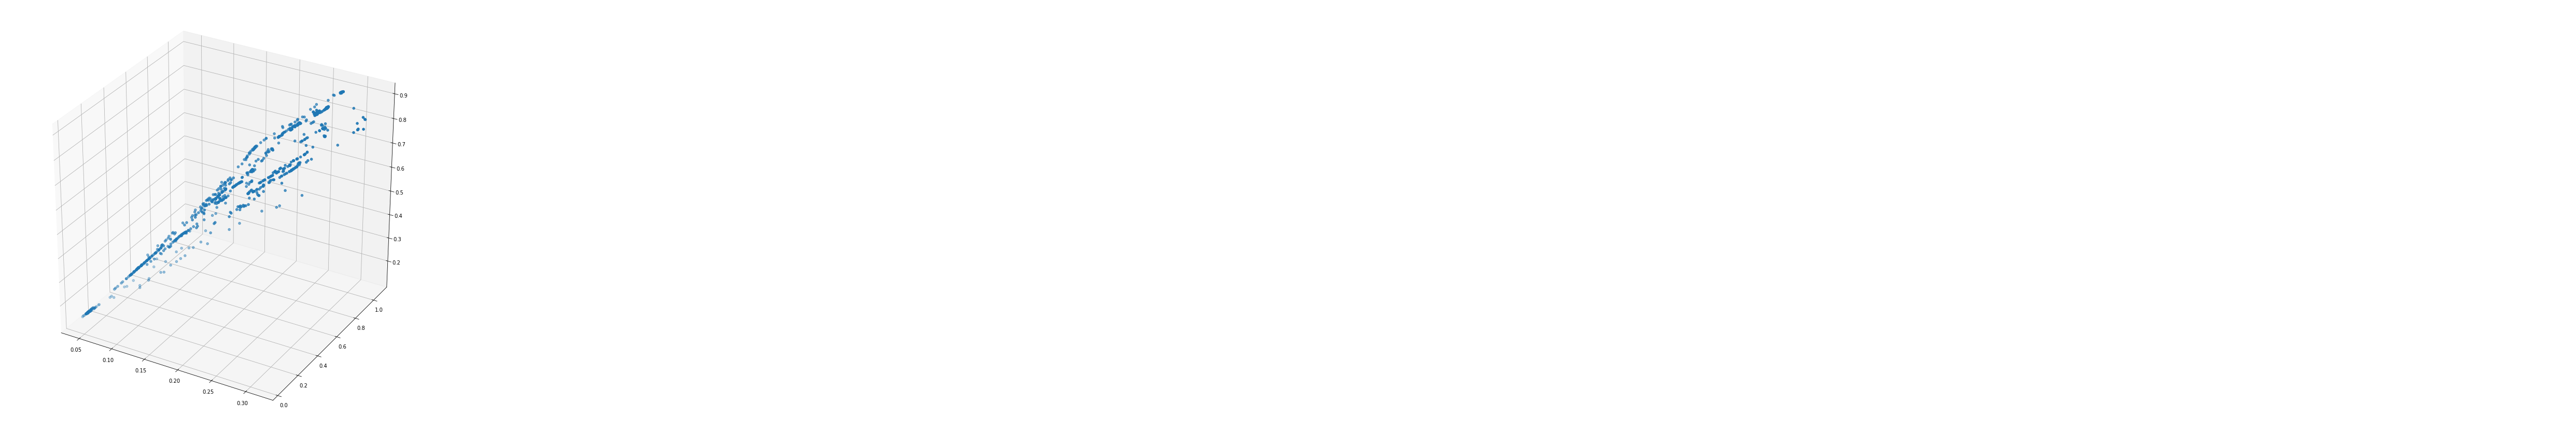

In [31]:
pts3D[:,2] = 1000*pts3D[:,2]
pts3D[:,0] = 1000*pts3D[:,0]
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(15, 15)
ax.scatter3D(pts3D[:,2],pts3D[:,0],pts3D[:,1]);

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [16]:
pts3D.shape

(1366031, 3)

In [15]:
pts3D[ptsC[:] != (255,255,255)].shape

(198711,)

In [38]:
#PointCloud = open3d.PointCloud()
#PointCloud.points = open3d.Vector3dVector(pts3D)
#PointCloud.colors = open3d.Vector3dVector(ptsC)
#open3d.write_point_cloud("test.ply", PointCloud)
pcd_load = open3d.read_point_cloud("final.ply")
open3d.draw_geometries([pcd_load])
#print(np.asarray(PointCloud.colors))
